In [1]:
import os
os.environ['NUMEXPR_MAX_THREADS'] = '12'

import pandas as pd
import matplotlib.pylab as plt
import numpy as np
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import itertools
%matplotlib inline

from fbprophet import Prophet
from fbprophet.plot import plot_plotly
import plotly.offline as py
from fbprophet.plot import add_changepoints_to_plot
from fbprophet.plot import plot_yearly

pd.plotting.register_matplotlib_converters()

In [2]:
# Read csv with total net sales daily
df = pd.read_csv('../data/net_sales_total.csv')
df['date'] = pd.to_datetime(df['date'])
df = df.set_index('date')

In [3]:
# Read csv with daily weather
weather_df = pd.read_csv('../data/dark_sky_api.csv')
weather_df['time'] = pd.to_datetime(weather_df['time'])
weather_df = weather_df.rename(columns={'time':'date'})
weather_df = weather_df.set_index('date')

# Merge both dataframes
df = df.merge(weather_df, on='date')

In [4]:
# Set Freq as 'D'
df = df.asfreq('D')

In [5]:
## Visual Check for duplicates
# df[df.index.duplicated(keep=False)]

In [6]:
df.head()

,total,summary,icon,sunriseTime,sunsetTime,moonPhase,precipIntensity,precipIntensityMax,precipIntensityMaxTime,precipProbability,...,temperatureMin,temperatureMinTime,temperatureMax,temperatureMaxTime,apparentTemperatureMin,apparentTemperatureMinTime,apparentTemperatureMax,apparentTemperatureMaxTime,ozone,Unnamed: 39
date,,,,,,,,,,,,,,,,,,,,,
2015-01-01,2249.22,Clear throughout the day.,clear-day,1420114920,1420148460,0.40,0.0000,0.0000,NaN,0.0,...,23.40,1420113780,39.47,1420144860,20.90,1420110180,35.46,1420147860,NaN,NaN
2015-01-02,1682.68,Mostly cloudy throughout the day.,partly-cloudy-day,1420201320,1420234920,0.43,0.0000,0.0000,NaN,0.0,...,31.96,1420257600,42.82,1420226040,29.76,1420196160,38.64,1420231080,NaN,NaN
2015-01-03,2550.18,Rain starting in the afternoon.,rain,1420287720,1420321380,0.46,0.0243,0.1062,NaN,1.0,...,28.97,1420283040,41.71,1420336080,29.46,1420283040,41.21,1420336080,NaN,NaN
2015-01-04,1964.54,"Light rain until morning, starting again in th...",rain,1420374120,1420407840,0.50,0.0139,0.1195,NaN,1.0,...,38.81,1420347600,55.25,1420415160,39.30,1420347600,54.75,1420415160,NaN,NaN
2015-01-05,1029.82,Partly cloudy throughout the day.,partly-cloudy-day,1420460520,1420494300,0.53,0.0000,0.0000,NaN,0.0,...,21.20,1420516800,49.74,1420434000,14.61,1420516800,45.21,1420434000,NaN,NaN


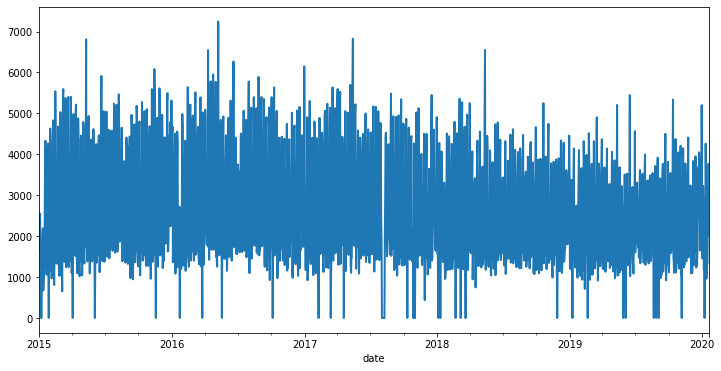

In [7]:
df['total'].plot(figsize=(12,6), linewidth=2, fontsize=10);

In [8]:
roll_mean = df['total'].rolling(window=7, center=False).mean()
roll_std = df['total'].rolling(window=7, center=False).std()

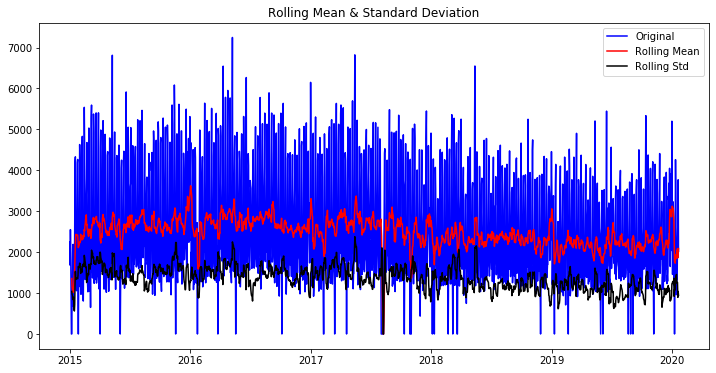

In [9]:
fig = plt.figure(figsize=(12,6))
plt.plot(df['total'], color='blue',label='Original')
plt.plot(roll_mean, color='red', label='Rolling Mean')
plt.plot(roll_std, color='black', label = 'Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show()

In [10]:
from statsmodels.tsa.stattools import adfuller

# Perform Dickey-Fuller test:
print ('Results of Dickey-Fuller Test: \n')
dftest = adfuller(df['total'])

# Extract and display test results in a user friendly manner
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

Results of Dickey-Fuller Test: 

Test Statistic                -5.823372e+00
p-value                        4.133029e-07
#Lags Used                     2.300000e+01
Number of Observations Used    1.822000e+03
Critical Value (1%)           -3.433944e+00
Critical Value (5%)           -2.863128e+00
Critical Value (10%)          -2.567615e+00
dtype: float64


In [11]:
def stationarity_check(TS):
    
    # Import adfuller
    from statsmodels.tsa.stattools import adfuller
    
    # Calculate rolling statistics
    roll_mean = TS.rolling(window=8, center=False).mean()
    roll_std = TS.rolling(window=8, center=False).std()
    
    # Perform the Dickey Fuller Test
    dftest = adfuller(TS['total'])
    
    # Plot rolling statistics:
    fig = plt.figure(figsize=(12,6))
    plt.plot(TS, color='blue',label='Original')
    plt.plot(roll_mean, color='red', label='Rolling Mean')
    plt.plot(roll_std, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    # Print Dickey-Fuller test results
    print('Results of Dickey-Fuller Test: \n')

    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', 
                                             '#Lags Used', 'Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    
    return None

In [12]:
df1 = df[['total']]

In [13]:
df1.head()

,total
date,
2015-01-01,2249.22
2015-01-02,1682.68
2015-01-03,2550.18
2015-01-04,1964.54
2015-01-05,1029.82


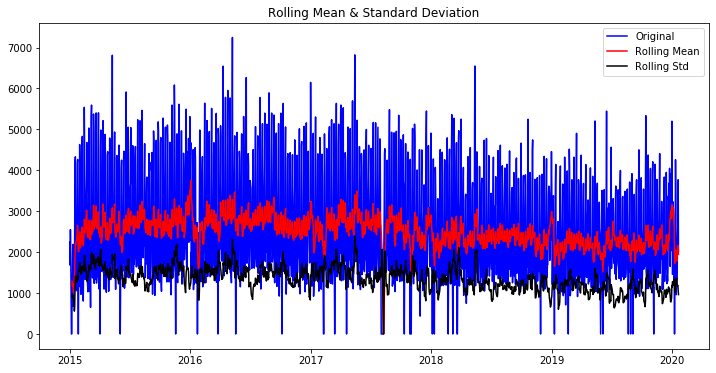

Results of Dickey-Fuller Test: 

Test Statistic                -5.823372e+00
p-value                        4.133029e-07
#Lags Used                     2.300000e+01
Number of Observations Used    1.822000e+03
Critical Value (1%)           -3.433944e+00
Critical Value (5%)           -2.863128e+00
Critical Value (10%)          -2.567615e+00
dtype: float64


In [14]:
stationarity_check(df1)

/Users/kennymiyasato/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning:

divide by zero encountered in log



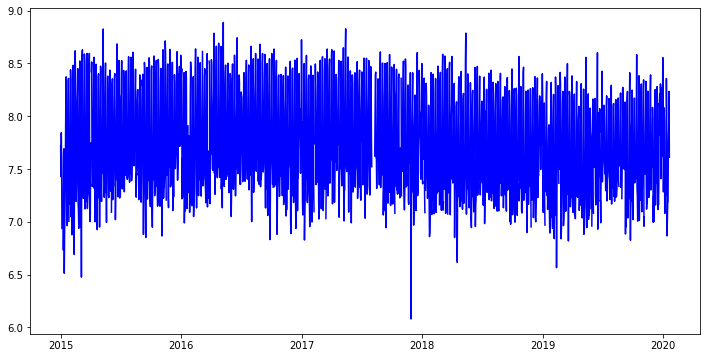

In [15]:
df1_log = np.log(df1)
fig = plt.figure(figsize=(12,6))
plt.plot(df1_log, color='blue');

/Users/kennymiyasato/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning:

divide by zero encountered in log

/Users/kennymiyasato/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning:

divide by zero encountered in log



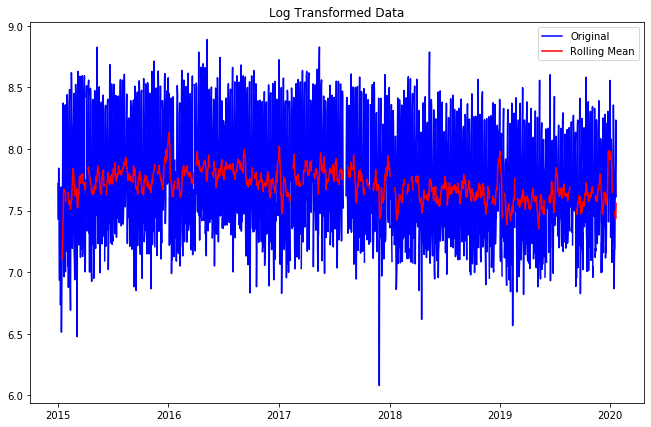

In [16]:
roll_mean = np.log(df1).rolling(window=7).mean()
fig = plt.figure(figsize=(11,7))
plt.plot(np.log(df1), color='blue', label='Original')
plt.plot(roll_mean, color='red', label='Rolling Mean')
plt.legend(loc='best')
plt.title('Log Transformed Data')
plt.show(block=False)

In [17]:
# Subtract the moving average from the log transformed data
data_minus_roll_mean = np.log(df1) - roll_mean

# Print the first 10 rows
data_minus_roll_mean.head()

/Users/kennymiyasato/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning:

divide by zero encountered in log



,total
date,
2015-01-01,NaN
2015-01-02,NaN
2015-01-03,NaN
2015-01-04,NaN
2015-01-05,NaN


In [18]:
# Drop the missing values
data_minus_roll_mean.dropna(inplace=True)

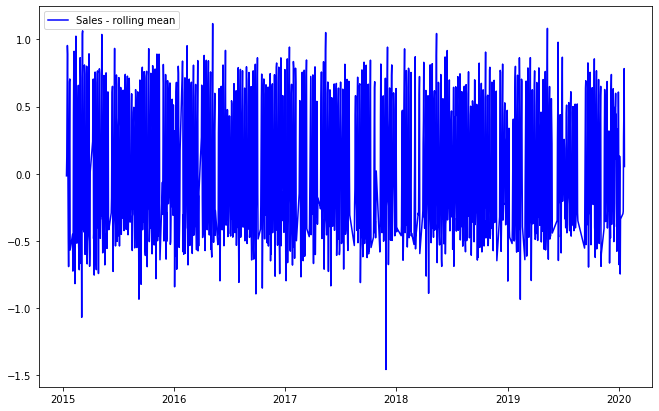

In [19]:
fig = plt.figure(figsize=(11,7))
plt.plot(data_minus_roll_mean, color='blue',label='Sales - rolling mean')
plt.legend(loc='best')
plt.show(block=False)

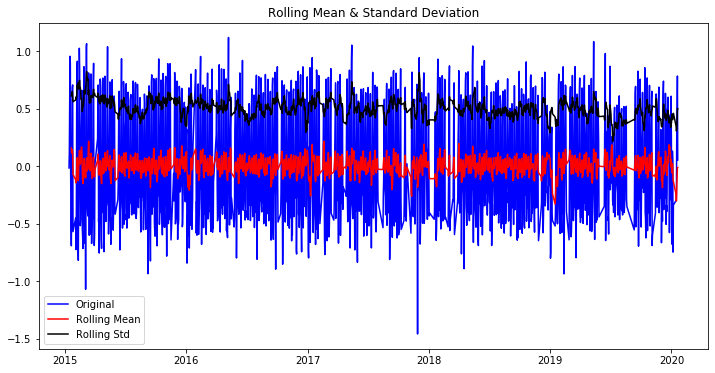

Results of Dickey-Fuller Test: 

Test Statistic                -1.204720e+01
p-value                        2.648077e-22
#Lags Used                     2.100000e+01
Number of Observations Used    1.596000e+03
Critical Value (1%)           -3.434454e+00
Critical Value (5%)           -2.863353e+00
Critical Value (10%)          -2.567735e+00
dtype: float64


In [20]:
stationarity_check(data_minus_roll_mean)

/Users/kennymiyasato/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning:

divide by zero encountered in log

/Users/kennymiyasato/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning:

divide by zero encountered in log



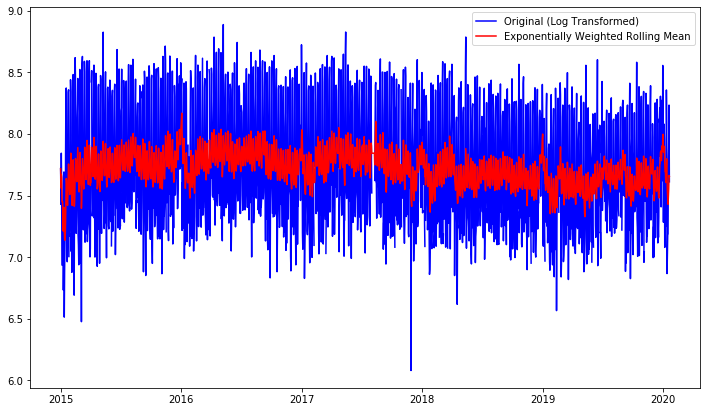

In [21]:
exp_roll_mean = np.log(df1).ewm(halflife=4).mean()

# Plot the original data with exp weighted average
fig = plt.figure(figsize=(12,7))
plt.plot(np.log(df1), color='blue',label='Original (Log Transformed)')
plt.plot(exp_roll_mean, color='red', label='Exponentially Weighted Rolling Mean')
plt.legend(loc='best')
plt.show(block=False)

In [22]:
# Difference your data
data_diff = exp_roll_mean.diff(periods=7)

# Drop the missing values
data_diff.dropna(inplace=True)

# Check out the first few rows
data_diff.head(15)

,total
date,
2015-01-08,-0.493759
2015-01-09,-0.349459
2015-01-10,-0.352154
2015-01-11,-0.239936
2015-01-12,-0.234492
2015-01-13,-0.301498
2015-01-14,-0.312703
2015-01-15,-0.055079
2015-01-16,0.085995


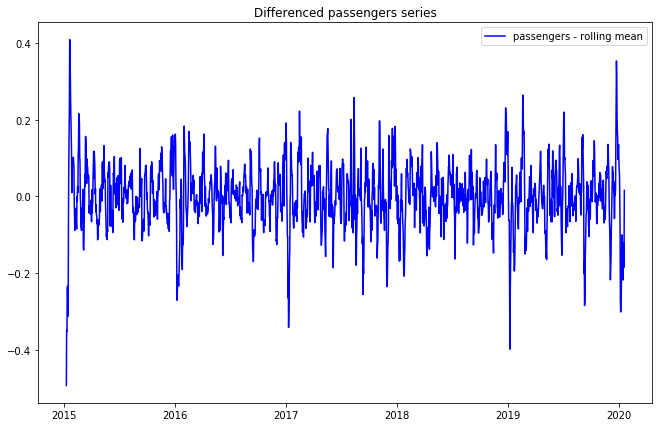

In [23]:
fig = plt.figure(figsize=(11,7))
plt.plot(data_diff, color='blue',label='passengers - rolling mean')
plt.legend(loc='best')
plt.title('Differenced passengers series')
plt.show(block=False)

In [24]:
data_diff

,total
date,
2015-01-08,-0.493759
2015-01-09,-0.349459
2015-01-10,-0.352154
2015-01-11,-0.239936
2015-01-12,-0.234492
...,...
2020-01-16,-0.185257
2020-01-17,-0.121394
2020-01-18,-0.186039


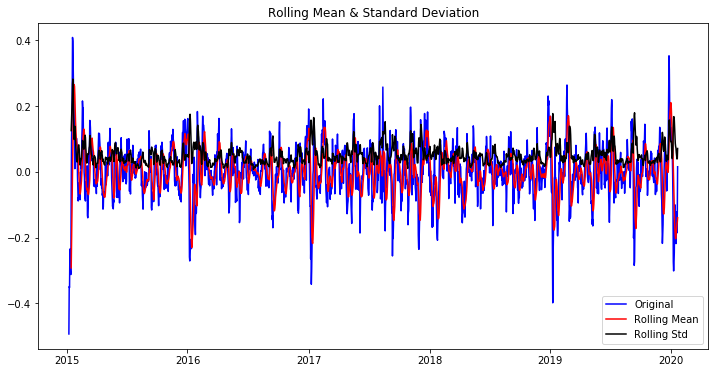

Results of Dickey-Fuller Test: 

Test Statistic                -1.079708e+01
p-value                        2.062428e-19
#Lags Used                     2.500000e+01
Number of Observations Used    1.813000e+03
Critical Value (1%)           -3.433962e+00
Critical Value (5%)           -2.863136e+00
Critical Value (10%)          -2.567619e+00
dtype: float64


In [25]:
stationarity_check(data_diff)

In [26]:
df1_log = np.log(df1)

/Users/kennymiyasato/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning:

divide by zero encountered in log



In [27]:
df1_diff = df1_log.diff(periods=7)
df1_diff.replace([np.inf, -np.inf], np.nan)
df1_diff.dropna(inplace=True)
df1_diff.head()

,total
date,
2015-01-08,-0.981229
2015-01-09,-0.252409
2015-01-10,-0.190220
2015-01-11,0.108616
2015-01-12,-0.424236


In [28]:
df_total = df[['total']]

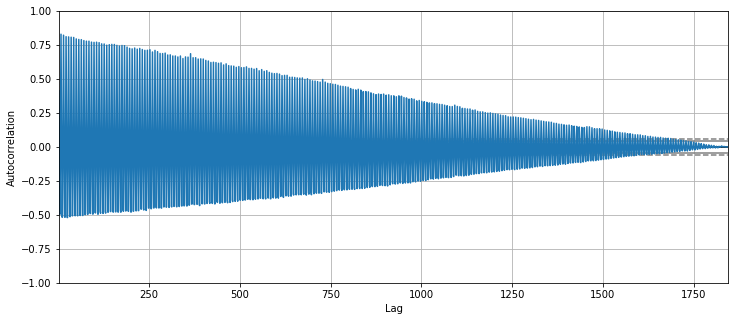

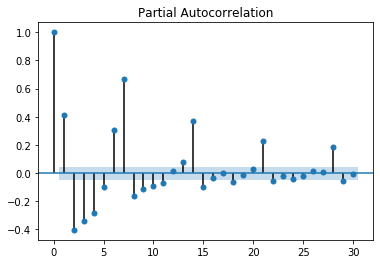

In [29]:
plt.figure(figsize=(12,5))
pd.plotting.autocorrelation_plot(df_total);

plot_pacf(df_total.dropna(), lags=30, method='ywm');

In [30]:
df_total_diff = df_total.diff(periods=7)

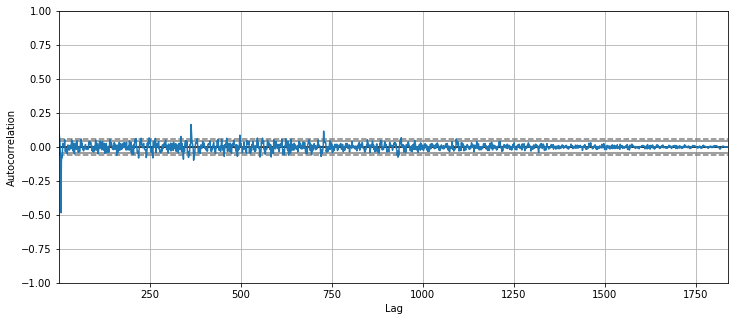

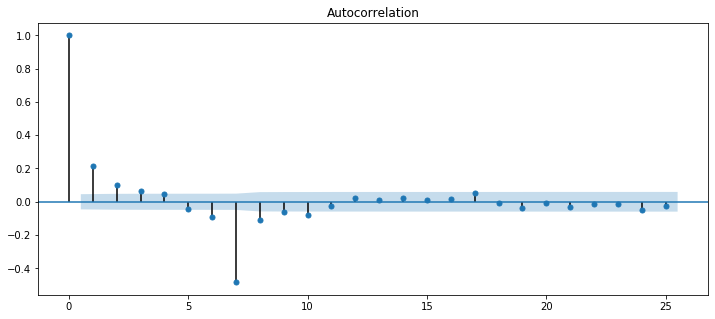

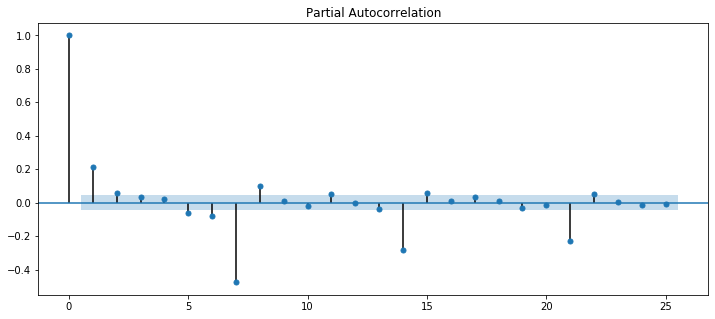

In [31]:
plt.figure(figsize=(12,5))
pd.plotting.autocorrelation_plot(df_total_diff.dropna());

fig, ax = plt.subplots(figsize=(12,5))
plot_acf(df_total_diff.dropna(), ax = ax, lags=25);

fig, ax = plt.subplots(figsize=(12,5))
plot_pacf(df_total_diff.dropna(), ax = ax, lags=25);

# ARMA

In [32]:
# assuming your time series are stored in an object "series"
# Import the ARMA module from statsmodels
from statsmodels.tsa.arima_model import ARMA

# Fit an MA(1) model to the first simulated data
mod_arma = ARMA(df_total_diff.dropna()['total'], order=(1,0))
res_arma = mod_arma.fit()

# Print out summary information on the fit
print(res_arma.summary())

# Print out the estimate for the constant and for theta
print(res_arma.params)

                              ARMA Model Results                              
Dep. Variable:                  total   No. Observations:                 1839
Model:                     ARMA(1, 0)   Log Likelihood              -14810.435
Method:                       css-mle   S.D. of innovations            760.956
Date:                Wed, 22 Jan 2020   AIC                          29626.871
Time:                        17:41:47   BIC                          29643.422
Sample:                    01-08-2015   HQIC                         29632.974
                         - 01-20-2020                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           2.7301     22.636      0.121      0.904     -41.636      47.096
ar.L1.total     0.2162      0.023      9.486      0.000       0.172       0.261
                                    Roots       

In [33]:
from statsmodels.tsa.arima_model import ARMA
import statsmodels.api as sm

# Fit an MA(1) model to the first simulated data
mod_arma = ARMA(df_total_diff.dropna()['total'], order=(0,1))
res_arma = mod_arma.fit()

# Print out summary information on the fit
print(res_arma.summary())

                              ARMA Model Results                              
Dep. Variable:                  total   No. Observations:                 1839
Model:                     ARMA(0, 1)   Log Likelihood              -14815.800
Method:                       css-mle   S.D. of innovations            763.181
Date:                Wed, 22 Jan 2020   AIC                          29637.600
Time:                        17:41:47   BIC                          29654.151
Sample:                    01-08-2015   HQIC                         29643.703
                         - 01-20-2020                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           2.7895     21.206      0.132      0.895     -38.774      44.353
ma.L1.total     0.1917      0.021      9.001      0.000       0.150       0.233
                                    Roots       

# SARIMA

In [33]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
pdqs = [(x[0], x[1], x[2], 7) for x in list(itertools.product(p, d, q))]

In [34]:
%%time
# Run a grid with pdq and seasonal pdq parameters calculated above and get the best AIC value
ans = []
for comb in pdq:
    for combs in pdqs:
        try:
            mod = sm.tsa.statespace.SARIMAX(df_total['total'],
                                            order=comb,
                                            seasonal_order=combs,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            output = mod.fit()
            ans.append([comb, combs, output.aic])
            print('ARIMA {} x {}7 : AIC Calculated ={}'.format(comb, combs, output.aic))
        except:
            continue


ARIMA (0, 0, 0) x (0, 0, 0, 7)7 : AIC Calculated =34182.76020013328
ARIMA (0, 0, 0) x (0, 0, 1, 7)7 : AIC Calculated =32413.994329804955
ARIMA (0, 0, 0) x (0, 1, 0, 7)7 : AIC Calculated =29391.43857232241
ARIMA (0, 0, 0) x (0, 1, 1, 7)7 : AIC Calculated =28496.454725575284
ARIMA (0, 0, 0) x (1, 0, 0, 7)7 : AIC Calculated =29377.698692034726
ARIMA (0, 0, 0) x (1, 0, 1, 7)7 : AIC Calculated =28627.128648330632
ARIMA (0, 0, 0) x (1, 1, 0, 7)7 : AIC Calculated =28832.567162501215
ARIMA (0, 0, 0) x (1, 1, 1, 7)7 : AIC Calculated =28447.442221506317
ARIMA (0, 0, 1) x (0, 0, 0, 7)7 : AIC Calculated =32690.509206440427
ARIMA (0, 0, 1) x (0, 0, 1, 7)7 : AIC Calculated =31486.51834046697
ARIMA (0, 0, 1) x (0, 1, 0, 7)7 : AIC Calculated =29293.05106238592
ARIMA (0, 0, 1) x (0, 1, 1, 7)7 : AIC Calculated =28308.477560858697
ARIMA (0, 0, 1) x (1, 0, 0, 7)7 : AIC Calculated =29283.2755778167
ARIMA (0, 0, 1) x (1, 0, 1, 7)7 : AIC Calculated =28445.192622037994
ARIMA (0, 0, 1) x (1, 1, 0, 7)7 : AIC Ca

C:\Users\Kenny\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA (0, 1, 1) x (1, 0, 1, 7)7 : AIC Calculated =28531.599843622516
ARIMA (0, 1, 1) x (1, 1, 0, 7)7 : AIC Calculated =28823.502148130625
ARIMA (0, 1, 1) x (1, 1, 1, 7)7 : AIC Calculated =28264.279249663523
ARIMA (1, 0, 0) x (0, 0, 0, 7)7 : AIC Calculated =31647.89395465731
ARIMA (1, 0, 0) x (0, 0, 1, 7)7 : AIC Calculated =30684.997052527906
ARIMA (1, 0, 0) x (0, 1, 0, 7)7 : AIC Calculated =29294.349167074168
ARIMA (1, 0, 0) x (0, 1, 1, 7)7 : AIC Calculated =28295.38106617055
ARIMA (1, 0, 0) x (1, 0, 0, 7)7 : AIC Calculated =29248.168215203506
ARIMA (1, 0, 0) x (1, 0, 1, 7)7 : AIC Calculated =28415.519535812404
ARIMA (1, 0, 0) x (1, 1, 0, 7)7 : AIC Calculated =28703.98179006637
ARIMA (1, 0, 0) x (1, 1, 1, 7)7 : AIC Calculated =28267.513663288544
ARIMA (1, 0, 1) x (0, 0, 0, 7)7 : AIC Calculated =31623.509061410616
ARIMA (1, 0, 1) x (0, 0, 1, 7)7 : AIC Calculated =30400.5329638405
ARIMA (1, 0, 1) x (0, 1, 0, 7)7 : AIC Calculated =29271.72718546461
ARIMA (1, 0, 1) x (0, 1, 1, 7)7 : AIC Ca

C:\Users\Kenny\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA (1, 0, 1) x (1, 0, 1, 7)7 : AIC Calculated =29785.324604968577
ARIMA (1, 0, 1) x (1, 1, 0, 7)7 : AIC Calculated =28690.856118691372
ARIMA (1, 0, 1) x (1, 1, 1, 7)7 : AIC Calculated =28177.426083292936
ARIMA (1, 1, 0) x (0, 0, 0, 7)7 : AIC Calculated =31755.69697591185
ARIMA (1, 1, 0) x (0, 0, 1, 7)7 : AIC Calculated =30801.96286986708
ARIMA (1, 1, 0) x (0, 1, 0, 7)7 : AIC Calculated =29799.650947196533
ARIMA (1, 1, 0) x (0, 1, 1, 7)7 : AIC Calculated =28703.134523926827
ARIMA (1, 1, 0) x (1, 0, 0, 7)7 : AIC Calculated =29656.64563404667
ARIMA (1, 1, 0) x (1, 0, 1, 7)7 : AIC Calculated =28816.397777744758
ARIMA (1, 1, 0) x (1, 1, 0, 7)7 : AIC Calculated =29195.459644204304
ARIMA (1, 1, 0) x (1, 1, 1, 7)7 : AIC Calculated =28690.389629692327
ARIMA (1, 1, 1) x (0, 0, 0, 7)7 : AIC Calculated =31174.46982336256
ARIMA (1, 1, 1) x (0, 0, 1, 7)7 : AIC Calculated =30138.36310628539
ARIMA (1, 1, 1) x (0, 1, 0, 7)7 : AIC Calculated =29294.30446734755
ARIMA (1, 1, 1) x (0, 1, 1, 7)7 : AIC Ca

C:\Users\Kenny\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA (1, 1, 1) x (1, 0, 1, 7)7 : AIC Calculated =29358.821509978545
ARIMA (1, 1, 1) x (1, 1, 0, 7)7 : AIC Calculated =28695.50738786061
ARIMA (1, 1, 1) x (1, 1, 1, 7)7 : AIC Calculated =28197.30991381198
Wall time: 49.3 s


In [14]:
# Find the parameters with minimal AIC value.
ans_df = pd.DataFrame(ans, columns=['pdq', 'pdqs', 'aic'])
ans_df.loc[ans_df['aic'].idxmin()]

pdq        (1, 0, 2)
pdqs    (0, 1, 2, 7)
aic          27961.4
Name: 302, dtype: object

In [35]:
df_total['total']

date
2015-01-01       0.00
2015-01-02       0.00
2015-01-03       0.00
2015-01-04       0.00
2015-01-05       0.00
               ...   
2019-12-27    2325.50
2019-12-28    3277.75
2019-12-29    3919.75
2019-12-30    2041.50
2019-12-31    5200.25
Freq: D, Name: total, Length: 1826, dtype: float64

In [34]:
# plug the optimal parameter values into a new SARIMAX model.
ARIMA_MODEL = sm.tsa.statespace.SARIMAX(df_total['total'],
                                order=(1, 0, 1),
                                seasonal_order=(1, 1, 1, 7),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

output = ARIMA_MODEL.fit()

print(output.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6807      0.053     12.815      0.000       0.577       0.785
ma.L1         -0.4808      0.062     -7.757      0.000      -0.602      -0.359
ar.S.L7        0.0748      0.019      3.900      0.000       0.037       0.112
ma.S.L7       -0.9569      0.008   -123.112      0.000      -0.972      -0.942
sigma2      3.223e+05   4781.009     67.413      0.000    3.13e+05    3.32e+05


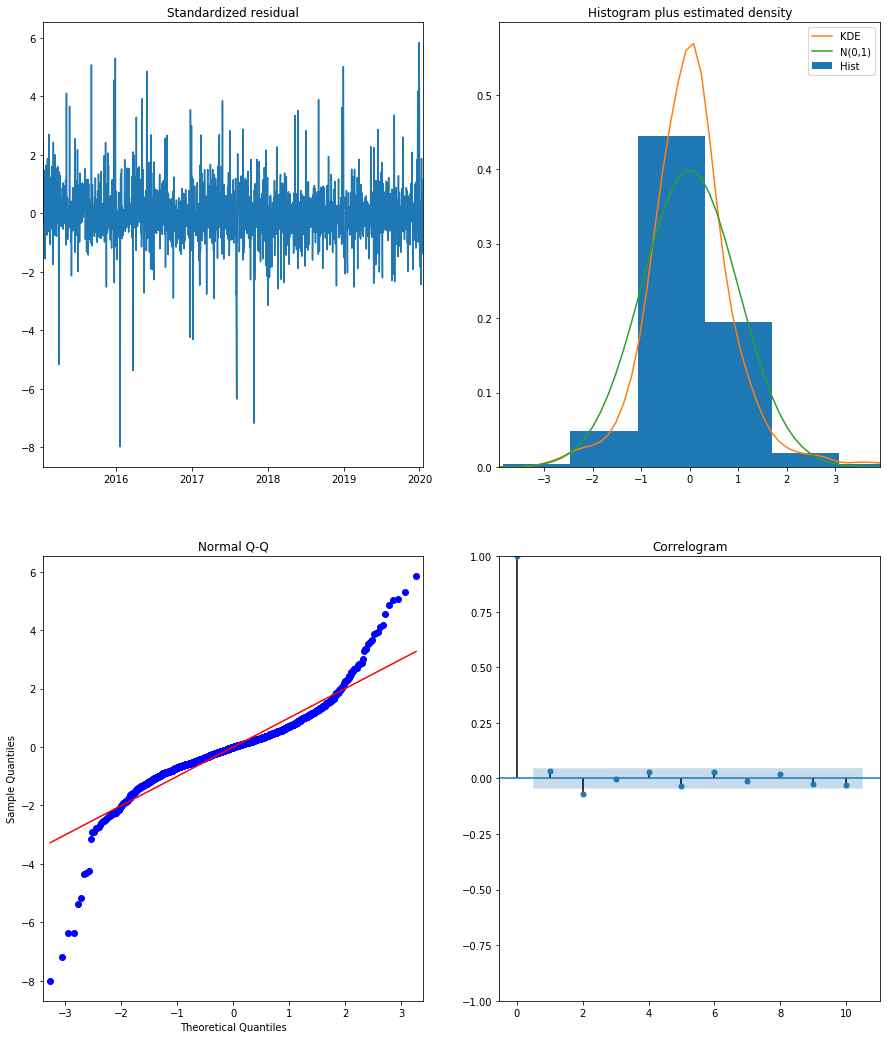

In [35]:
output.plot_diagnostics(figsize=(15, 18))
plt.show()

In [38]:
# plug the optimal parameter values into a new SARIMAX model.
ARIMA_MODEL = sm.tsa.statespace.SARIMAX(df_total['total'],
                                order=(1, 0, 2),
                                seasonal_order=(0, 1, 2, 7),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

output = ARIMA_MODEL.fit()

print(output.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7175      0.059     12.139      0.000       0.602       0.833
ma.L1         -0.5007      0.060     -8.291      0.000      -0.619      -0.382
ma.L2         -0.0723      0.029     -2.527      0.012      -0.128      -0.016
ma.S.L7       -0.9090      0.018    -49.720      0.000      -0.945      -0.873
ma.S.L14      -0.0435      0.019     -2.347      0.019      -0.080      -0.007
sigma2      3.162e+05   4626.409     68.356      0.000    3.07e+05    3.25e+05


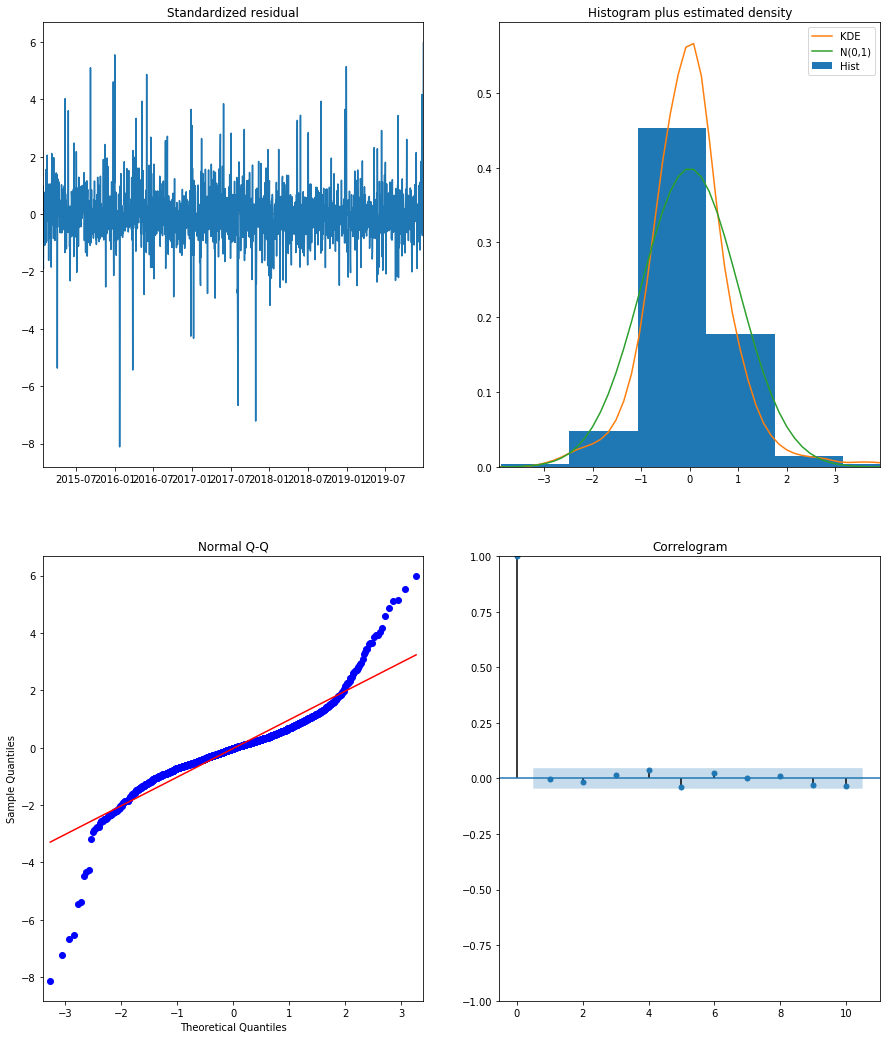

In [20]:
output.plot_diagnostics(figsize=(15, 18))
plt.show()

# Prophet

In [98]:
df.reset_index(inplace=True)
df = df.rename(columns={'date':'ds', 'total':'y'})

In [99]:
m = Prophet(daily_seasonality=True)
m.fit(df)

In [100]:
future = m.make_future_dataframe(periods=14)
future.tail()

,ds
1835,2020-01-10
1836,2020-01-11
1837,2020-01-12
1838,2020-01-13
1839,2020-01-14


In [101]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
1835,2020-01-10,1955.586311,1199.225864,2712.497931
1836,2020-01-11,3248.445500,2414.695674,3991.704573
1837,2020-01-12,3691.465111,2941.241380,4384.435011
1838,2020-01-13,836.762236,27.530316,1668.458980
1839,2020-01-14,718.323645,-5.564076,1554.082809


In [102]:
forecast.columns

Index(['ds', 'trend', 'yhat_lower', 'yhat_upper', 'trend_lower', 'trend_upper',
       'additive_terms', 'additive_terms_lower', 'additive_terms_upper',
       'daily', 'daily_lower', 'daily_upper', 'weekly', 'weekly_lower',
       'weekly_upper', 'yearly', 'yearly_lower', 'yearly_upper',
       'multiplicative_terms', 'multiplicative_terms_lower',
       'multiplicative_terms_upper', 'yhat'],
      dtype='object')

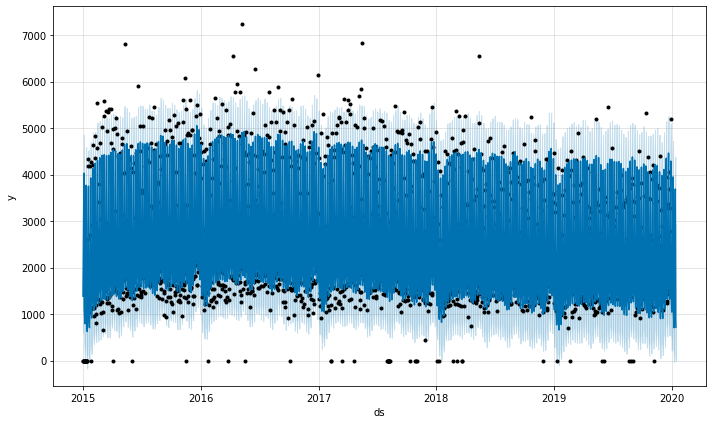

In [103]:
fig1 = m.plot(forecast)

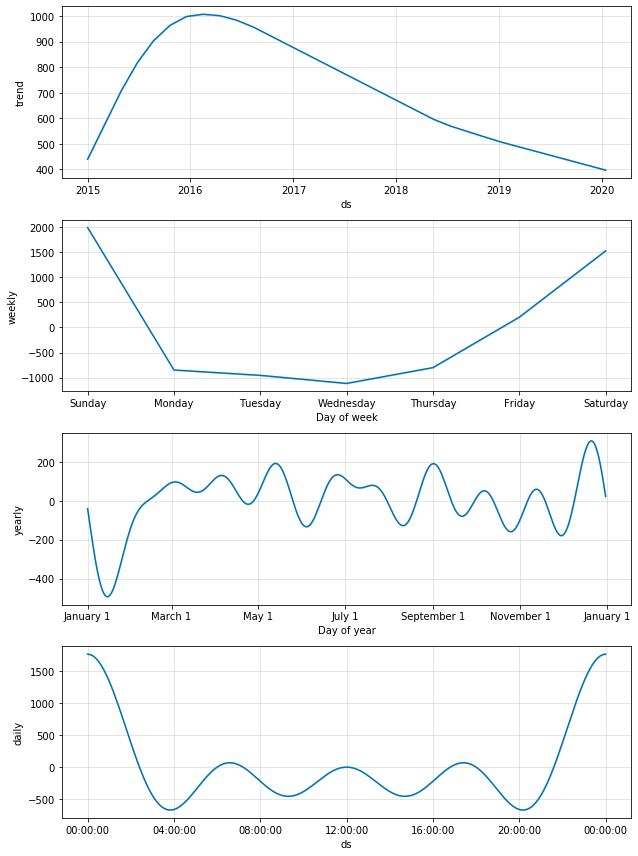

In [104]:
fig2 = m.plot_components(forecast)

In [105]:
fig = plot_plotly(m, forecast)  # This returns a plotly Figure
py.iplot(fig)

### Forecasting Growth

In [49]:
df['cap'] = 8.5

In [50]:
m = Prophet(growth='logistic', daily_seasonality=True)
m.fit(df)

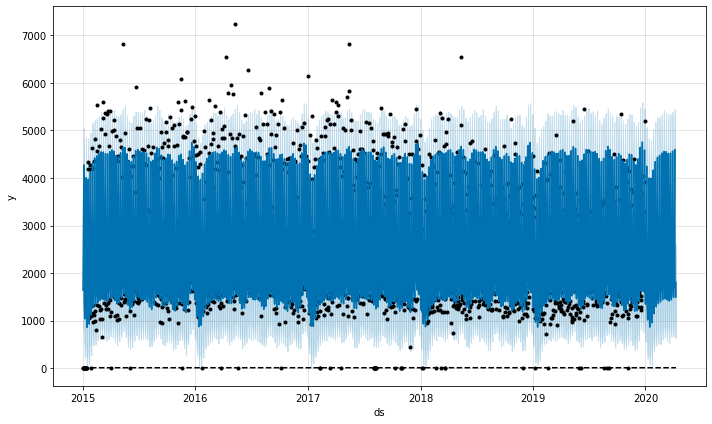

In [54]:
future = m.make_future_dataframe(periods=100)
future['cap'] = 8.5

fcst = m.predict(future)
fig = m.plot(fcst)

### Saturating Minimum

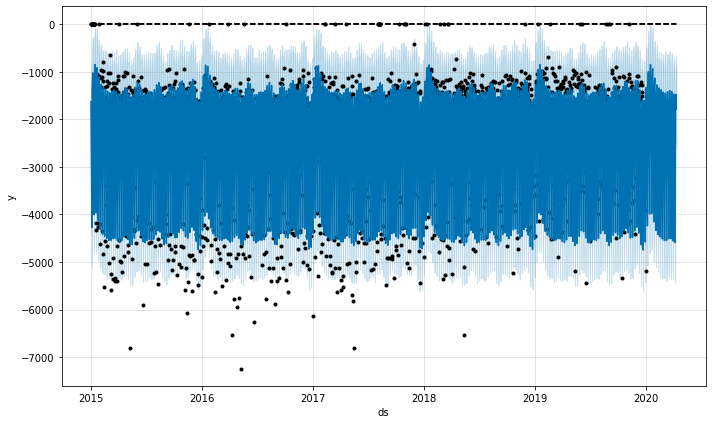

In [55]:
df['y'] = 10 - df['y']
df['cap'] = 6
df['floor'] = 1.5
future['cap'] = 6
future['floor'] = 1.5

m = Prophet(growth='logistic', daily_seasonality=True)
m.fit(df)
fcst = m.predict(future)
fig = m.plot(fcst)

### Automatic changepoint detection in Prophet

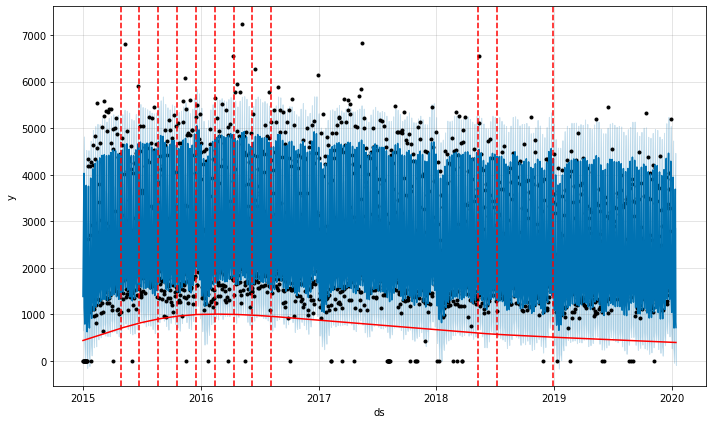

In [76]:
fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)

### Adjusting Trend Flixibility

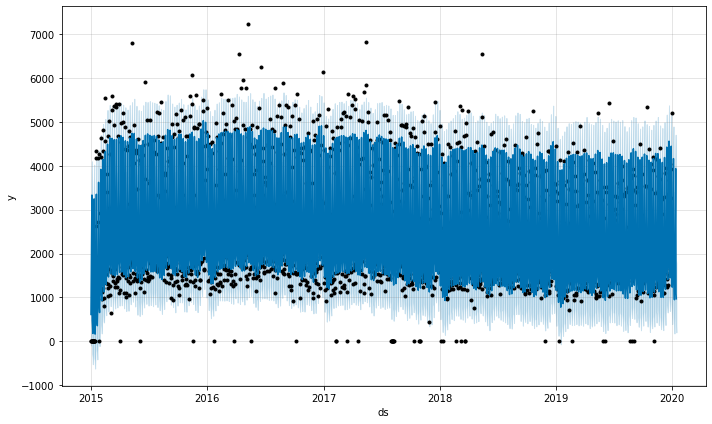

In [78]:
m = Prophet(changepoint_prior_scale=0.5, daily_seasonality=True)
forecast = m.fit(df).predict(future)
fig = m.plot(forecast)

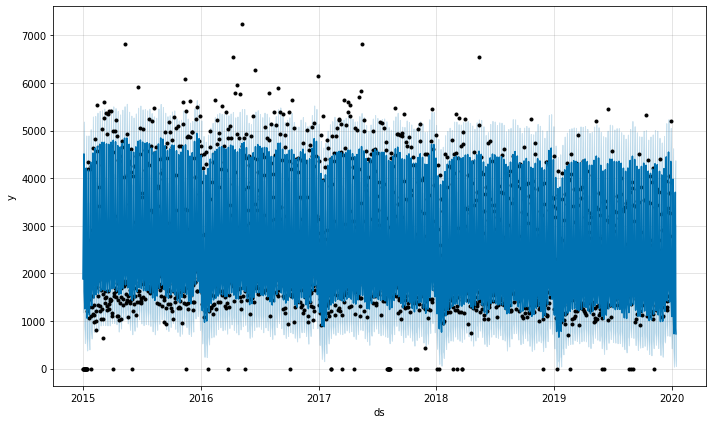

In [79]:
m = Prophet(changepoint_prior_scale=0.001, daily_seasonality=True)
forecast = m.fit(df).predict(future)
fig = m.plot(forecast)

### Modeling Holidays and Special Events

In [106]:
veintiocho = pd.DataFrame({
  'holiday': 'veintiocho',
  'ds': pd.to_datetime(['2015-07-28', '2016-07-28', 
                        '2017-07-28', '2018-07-28', 
                        '2019-07-28']),
  'lower_window': 0,
  'upper_window': 1,
})
holidays = veintiocho

In [107]:
m = Prophet(holidays=holidays, daily_seasonality=True)
forecast = m.fit(df).predict(future)

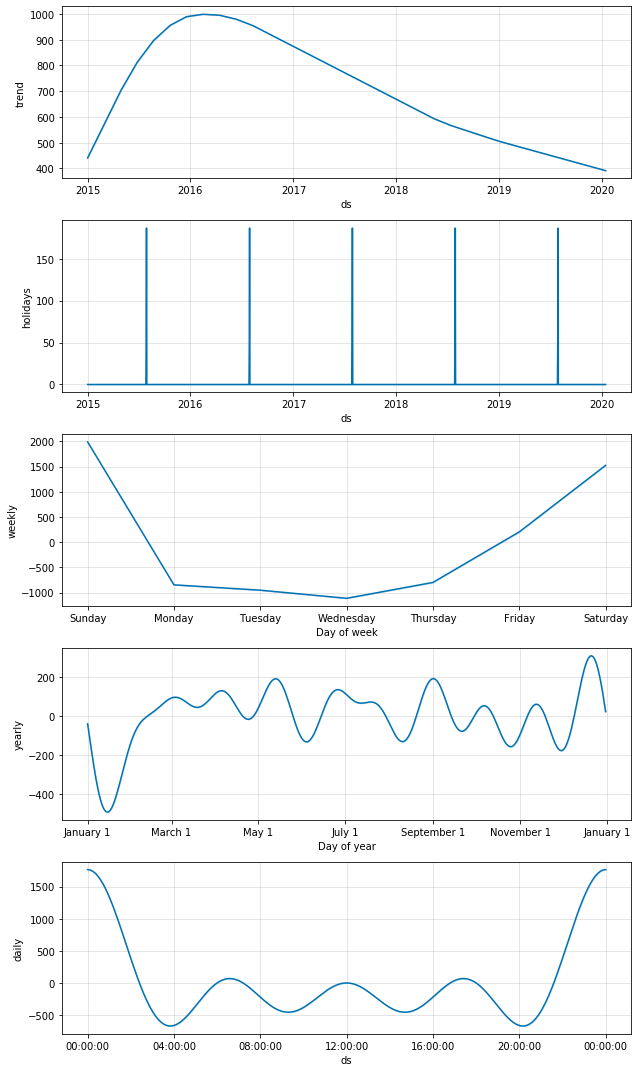

In [108]:
fig = m.plot_components(forecast)

In [109]:
m = Prophet(holidays=holidays, daily_seasonality=True)
m.add_country_holidays(country_name='US')
# m.add_country_holidays(country_name='PE')
m.fit(df)

In [110]:
m.train_holiday_names

0                      veintiocho
1                  New Year's Day
2     Martin Luther King, Jr. Day
3           Washington's Birthday
4                    Memorial Day
5                Independence Day
6                       Labor Day
7                    Columbus Day
8                    Veterans Day
9                    Thanksgiving
10                  Christmas Day
11       Christmas Day (Observed)
12      New Year's Day (Observed)
13        Veterans Day (Observed)
14    Independence Day (Observed)
dtype: object

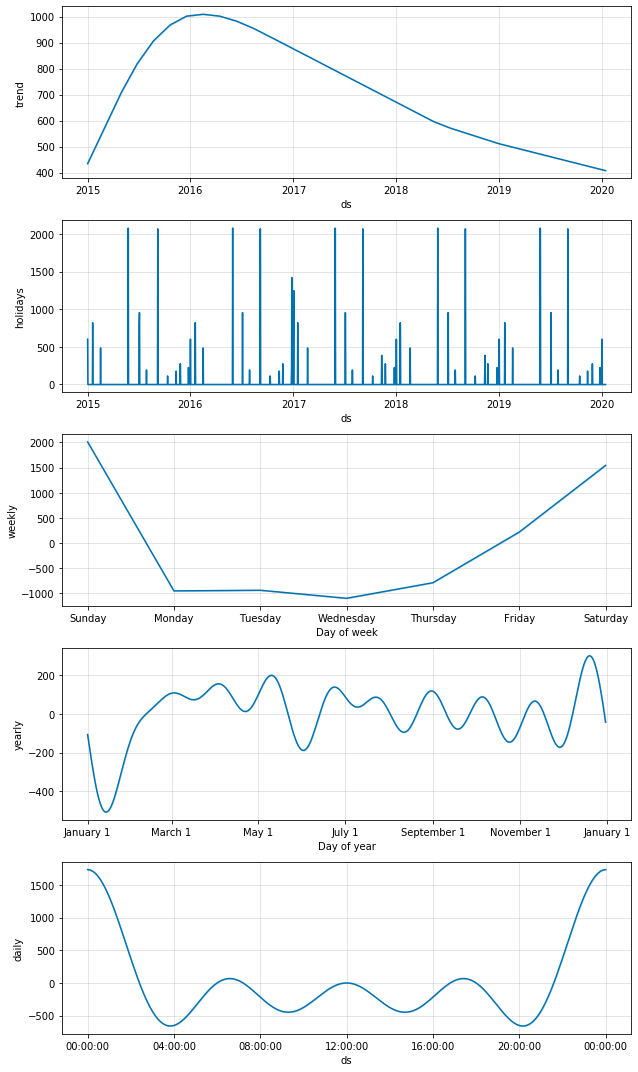

In [111]:
forecast = m.predict(future)
fig = m.plot_components(forecast)

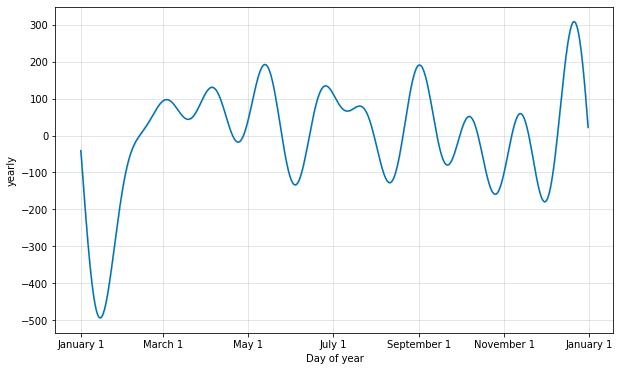

In [112]:
m = Prophet(daily_seasonality=True).fit(df)
a = plot_yearly(m)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


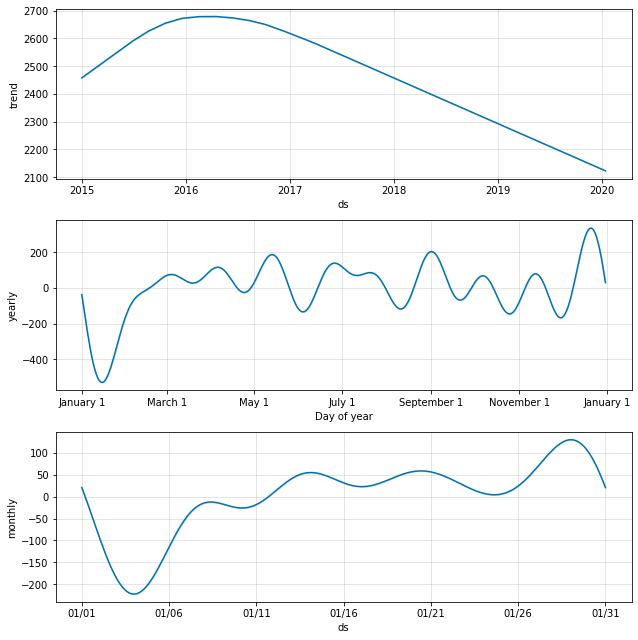

In [113]:
m = Prophet(weekly_seasonality=False)
m.add_seasonality(name='monthly', period=30.5, fourier_order=5)
forecast = m.fit(df).predict(future)
fig = m.plot_components(forecast)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


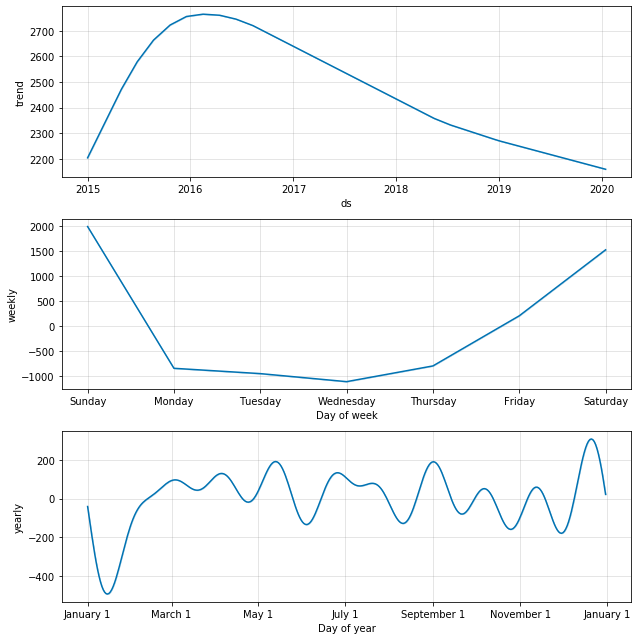

In [114]:
m = Prophet(weekly_seasonality=False)
m.add_seasonality(name='weekly', period=7, fourier_order=5)
forecast = m.fit(df).predict(future)
fig = m.plot_components(forecast)

In [115]:
df

,ds,y
0,2015-01-01,0.00
1,2015-01-02,0.00
2,2015-01-03,0.00
3,2015-01-04,0.00
4,2015-01-05,0.00
...,...,...
1821,2019-12-27,2325.50
1822,2019-12-28,3277.75
1823,2019-12-29,3919.75
1824,2019-12-30,2041.50
